# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении имеются исторические данные: технические характеристики, комплектации и цены автомобилей.

### Цель исследования 

 - <b>Построить модель для определения стоимости</b>

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Описание данных

<b>Признаки</b>
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

<b>Целевой признак</b>
- Price — цена (евро)

### Ход исследования

1) Подготовка данных

2) Обучение разных моделей

3) Анализ скорости работы и качества моделей

## Подготовка данных

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import time 

from sklearn.metrics import mean_squared_error as mse 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

RND = 12345

import warnings
warnings.filterwarnings('ignore')

In [5]:
try:
    df = pd.read_csv('/Users/vladislav/Documents/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [6]:
new_columns = df.columns.str.lower()
df.set_axis(new_columns, axis = 'columns', inplace = True)

Выгрузили данные и изменили названия столбцов в нижний регистр для удобства

In [7]:
def first_check(dataset):
    print(dataset.info())
    display(dataset.head())
    display(dataset.tail())
    display(df.describe())
    display(df.describe(include=['object', 'bool']))
    print('Duplicates: ', dataset.duplicated().sum())

In [8]:
first_check(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,datecrawled,vehicletype,gearbox,model,fueltype,brand,notrepaired,datecreated,lastseen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


Duplicates:  4


**Первичный анализ:**
- 354365 строк и 16 столбцов
- Присутствуют пропуски
- Средняя стоимость авто 2700 евро
- Минимальный год регистриции автомобиля 1000, максимальный - 9999. Предлагаю обозначить диапазон в годах, выделенных из процентилей
- Макс.значение в мощности автомобиля в лошадинных силах = 20 000. Показатель весьма фантастический. Выберем диапазон из процентилей
- Минимальный пробег авто 5000, максимальный - 150000, но при этом много авто имееют максимальный пробег. Возможно просто ограничение ввода данных на сайте
- Неправильно выставлены месяцы. Если первый месяц 0, то последний месяц не должен быть 12
- Столбец с фото автомобилей. У нас их нет

**-------------**

- 8 уникальных типов автомобильного кузова
- Чаще встречаются авто с ручной коробкой передач
- Чаще встречаются автомобиле на бензине
- Самый популярный бренд автомобиля Volkswagen
- Много пропусков в столбце о ремонте авто, но чаще встречаются автомобили без ремонта

В датасете присутствуют неинформативные признаки. Предлагаю не тратить на них время и работать в дальнейшем только с нужными признаками.

### Анализ и обработка

**Категориальные признаки**

<AxesSubplot:>

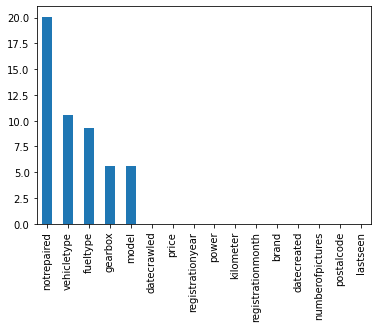

In [9]:
(df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100).plot(kind='bar')

 **Объем пропущенных значений составляют: **
 - 20% в столбце NotRepaired. Скорее всего владельцы пропустили это значения потому что авто прежде не ремонтировалось. Либо просто скрыли информацию, чтобы автомобиль не казался менее привлекательным к покупке
 - 10% в столбце VehicleType 
 - 9% в столбце FuelType
 - 5% в столбце GearBox
 - 5% в столбце Model

Остальные столбцы имеют пропуски возможно по причине проблем с выгрузкой данных, так как на эти вопросы может ответить только владельцы автомобилей. Заполним пропуски модами с помощью группировки по другим признакам объектов.

In [10]:
df['notrepaired'] = df['notrepaired'].fillna('no')

In [11]:
def fill_with_mode(column, column1, column2):
    df[column] = df.groupby([column1, column2])[column].transform(
        lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

In [12]:
fill_with_mode('model', 'brand', 'registrationyear')
fill_with_mode('fueltype', 'brand', 'model')
fill_with_mode('vehicletype', 'brand', 'model')
fill_with_mode('gearbox', 'brand', 'model')

In [13]:
filled_columns = ['model', 'gearbox', 'brand', 'vehicletype', 'fueltype']
def count_empty_category(column):
    print(column, ' : ' ,df[column][df[column] == 'Empty'].count())

In [14]:
for column in filled_columns:
    count_empty_category(column)

model  :  3442
gearbox  :  21
brand  :  0
vehicletype  :  25
fueltype  :  14


3442 объекта продажи с неизвестными моделями авто. Предлагаю их переименовать в Other. Остальные показатели малы.

In [15]:
df['model'] = df['model'].replace('Empty', 'other')

In [16]:
def make_plotbar(index, title):
    pivot = pd.DataFrame(df.pivot_table(index=index, aggfunc="size").sort_values(ascending=False)).head(10)
    pivot.columns = ['count']
    plt.figure(figsize=(12,6))
    plt.title(title)
    sns.barplot(x='count', y=pivot.index, data=pivot)

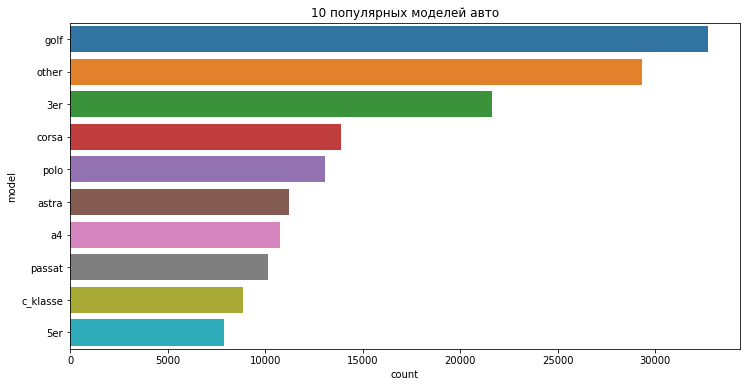

In [17]:
make_plotbar('model', '10 популярных моделей авто')

Самая популярная модель авто - golf

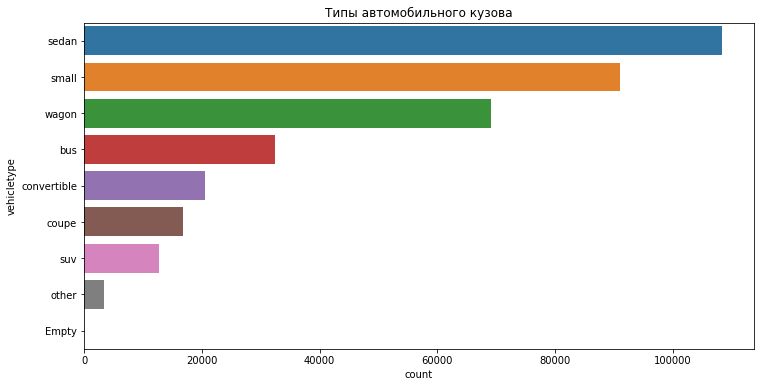

In [18]:
make_plotbar('vehicletype', 'Типы автомобильного кузова')

Самый популярный тип автомобильного кузова - седан

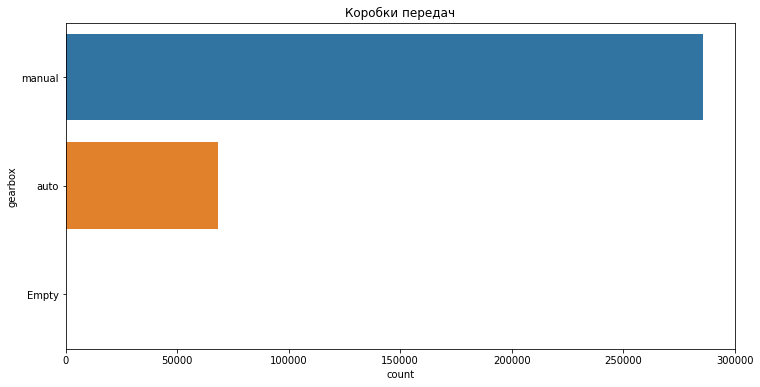

In [19]:
make_plotbar('gearbox', 'Коробки передач')

Автомобили с ручной коробкой передач превышают по количеству автомобили с автоматической коробкой передач

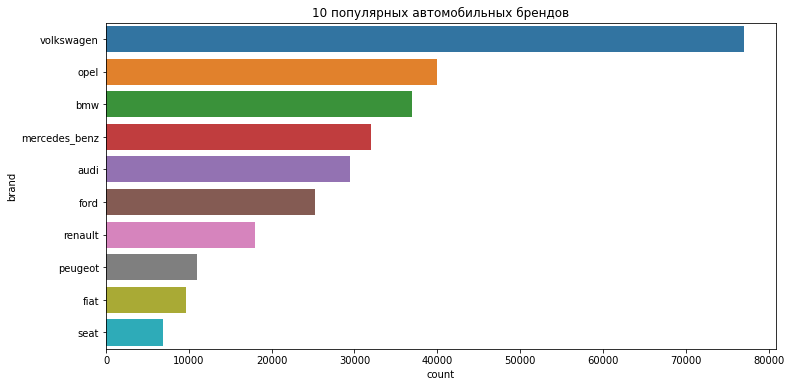

In [20]:
make_plotbar('brand', '10 популярных автомобильных брендов')

Volskwagen - самый продаваемый автомобиль

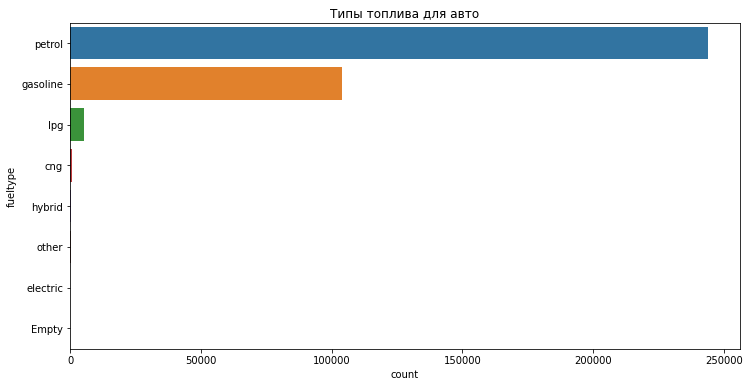

In [21]:
make_plotbar('fueltype', 'Типы топлива для авто')

Бензин - самое популярное топливо

**Количественные признаки**

In [22]:
cars_for_free = df.query('price == 0')
cars_for_free.shape

(10772, 16)

10772 автомобиля отдаются бесплатно. На фоне остального датасета это немного строк. Предлагаю их просто убрать

In [23]:
df = df.query('price != 0')

In [24]:
perc = np.arange(0,1,0.05)

In [25]:
df['power'].describe(percentiles = perc)

count    343597.000000
mean        111.000192
std         188.177974
min           0.000000
0%            0.000000
5%            0.000000
10%           0.000000
15%          54.000000
20%          60.000000
25%          69.000000
30%          75.000000
35%          82.000000
40%          90.000000
45%         101.000000
50%         105.000000
55%         110.000000
60%         116.000000
65%         125.000000
70%         136.000000
75%         143.000000
80%         150.000000
85%         170.000000
90%         180.000000
95%         218.000000
max       20000.000000
Name: power, dtype: float64

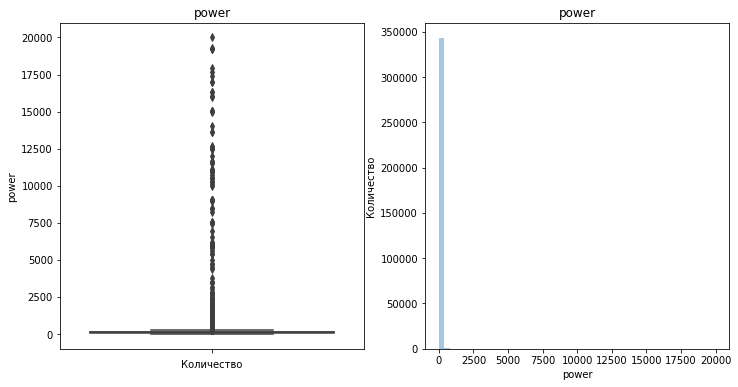

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title('power')
sns.boxplot(y = 'power', data=df, ax = axes[0])
axes[0].set_xlabel('Количество')
     
axes[1].set_title('power')
sns.distplot(df['power'], kde=False, bins=50, ax = axes[1])
axes[1].set_ylabel('Количество')
            
plt.show()

много выбросов, от этого график становится неинформативным

Text(0, 0.5, 'Количество')

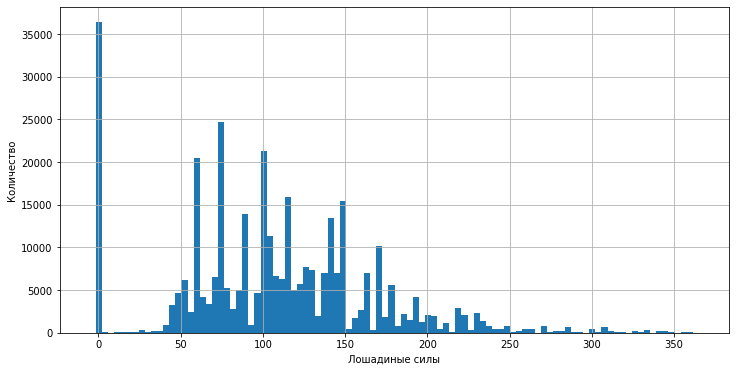

In [27]:
Q1 = df['power'].quantile(0.25)
Q3 = df['power'].quantile(0.75)
IQR = Q3 - Q1
fig, ax = plt.subplots()
df['power'].plot(kind = 'hist', bins = 100, grid = True, range = (Q1 - IQR, Q3 + 3*IQR), figsize = (12, 6))
ax.set_xlabel('Лошадиные силы')
ax.set_ylabel('Количество')

Мы взяли квантили от показателей столбца для графика, и судя по нему в основном встречаются авто с мощностью до 350 лс. Примем 350 лс как максимум диапазона, а нули заменим на медианы относительно групп моделей объектов

In [28]:
df = df.query('power <= 350')

In [29]:
medians  = df.groupby('model')['power'].median().to_dict()
def fill_with_median (row):
    if row['power'] == 0:
        return medians [row['model']]
    return row ['power']
df['power'] = df.apply(lambda row: fill_with_median(row), axis = 1)

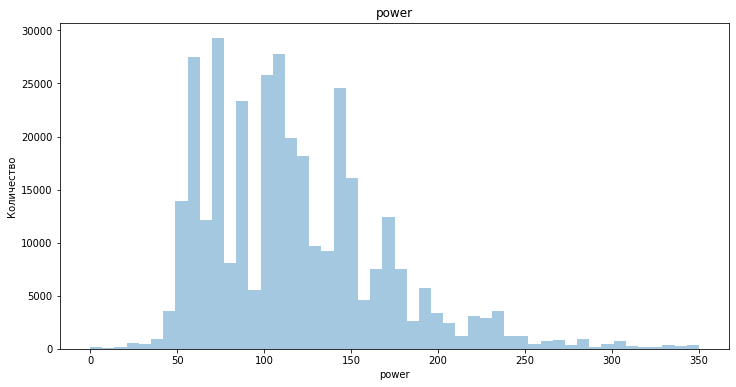

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('power')
sns.distplot(df['power'], kde=False, bins=50, ax = ax)
ax.set_ylabel('Количество')          
plt.show()

Убрали выбросы и нули из столбца Power

In [31]:
df['registrationyear'].describe(percentiles=perc)

count    342441.000000
mean       2004.074962
std          77.973936
min        1000.000000
0%         1000.000000
5%         1993.000000
10%        1996.000000
15%        1997.000000
20%        1998.000000
25%        1999.000000
30%        2000.000000
35%        2000.000000
40%        2001.000000
45%        2002.000000
50%        2003.000000
55%        2004.000000
60%        2005.000000
65%        2006.000000
70%        2007.000000
75%        2008.000000
80%        2009.000000
85%        2010.000000
90%        2012.000000
95%        2016.000000
max        9999.000000
Name: registrationyear, dtype: float64

Возьмем область от 5% в столбе года регистрации

In [32]:
df = df.query('registrationyear >= 1992 and registrationyear < 2020')

In [33]:
df = df.drop_duplicates().reset_index(drop=True)

Убрали дубликаты

In [34]:
def make_price_plot(feature, title):
    mean_price = df[[feature, 'price']].groupby(feature, as_index=False).mean().astype('int')
    plt.figure(figsize=(12,6))
    plt.grid(axis = 'both')
    sns.lineplot(x=feature, y='price', data=mean_price)
    plt.xlabel(feature, size=12)
    plt.ylabel('Средняя цена в евро', size=12)
    plt.title(title, size=15, y=1.02)
    plt.show()

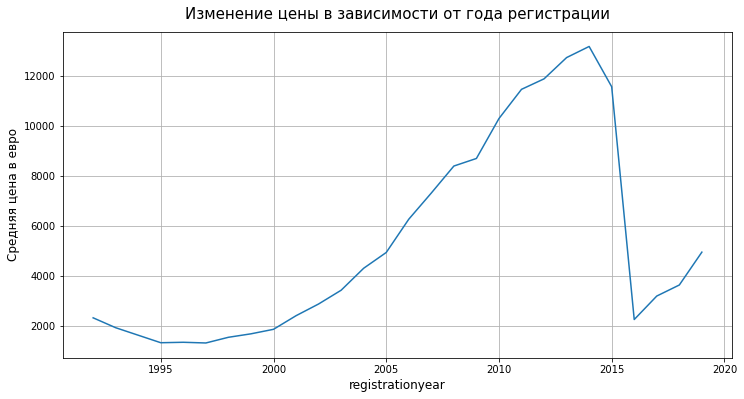

In [35]:
make_price_plot('registrationyear', 'Изменение цены в зависимости от года регистрации')

По всей вероятности, на ценообразование оказали влияние в 2015 какие-либо макроэкономические факторы.

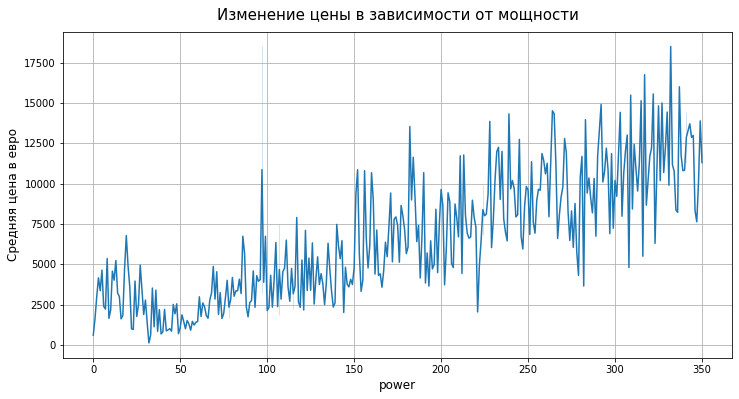

In [36]:
make_price_plot('power', 'Изменение цены в зависимости от мощности')

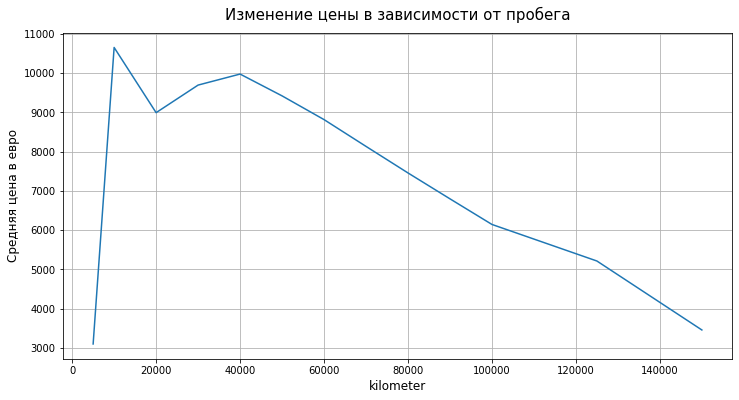

In [37]:
make_price_plot('kilometer', 'Изменение цены в зависимости от пробега')

In [38]:
df.shape

(328421, 16)

<AxesSubplot:>

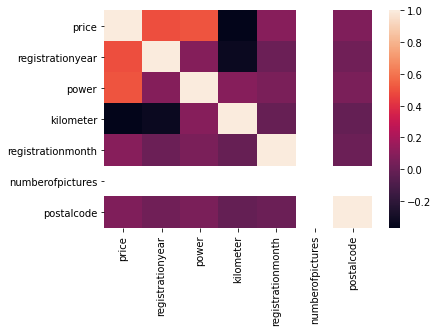

In [39]:
corr = df.corr()
sns.heatmap(corr)

In [40]:
df['price'].corr(df['kilometer'])

-0.3685454047844272

<b>Вывод этапа обработки данных:</b>

После анализа и обработки мы потеряли 1\10 данных. Вероятно, это не сильно повлияет на дальнейшую работу

* Наибольшее количество пропусков (20%) было в столбце NotRepaired. Скорее всего владельцы пропустили это значения потому что авто прежде не ремонтировалось. Либо просто скрыли информацию, чтобы автомобиль не казался менее привлекательным к покупке. В остальных столбцах доля пропусков была ниже, все пропуски заполнены.
* Наиболее популярной маркой автомобилей была Volkswagen;
* Наиболее популярная модель - Golf;
* Наиболее популярный тип кузова -  седан;
* Наиболее популярный тип коробки передач - механическая;
* Наиболее популярный тип топлива - бензин; 
* Для 10,7 тыс. автомобилей не была указана цена, данные строки были исключены из датасета;
* Из столбцов *power* и *registrationyear* были убраны выбросы и дубликаты;
* Во временном срезе в 2015 году по имеющимся данным можно наблюдать тенденцию глобального снижения объемов продаж  уровня цен.
* Зависимость уровня цен от пробега автомобиля имеется и логически обосновывается.
* По корреляционной матрице подтверждается, что имеется зависимость между ценой и возрастом авто (чем моложе автомобиль, тем выше цена), между ценой и мощностью (чем мощнее автомобиль, тем выше цена), а также отрицательная зависимость между ценой и пробегом (чем больше пробег, тем ниже цена).

## Обучение моделей

Features: 
 - Object: 
       'vehicletype', 'registrationyear', 'gearbox',
       'model', 'fueltype', 'brand',
       'notrepaired'
 - Int: 'power', 'kilometer'

Target: 'price'

Уберем ненужные столбцы, относящиеся к объявлению, но не к автомобилю, и, соответственно, не влияющие на его стоимость. 

In [41]:
df = df.drop(['datecrawled', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'], axis=1)

In [42]:
cats_cols = list(df.select_dtypes(include='object').columns)
label_encode = LabelEncoder()
for column in cats_cols:
    label_encode.fit(df[column].astype('str'))
    df[column] = label_encode.transform(df[column].astype('str'))

Провели кодирование категориальных данных с помощью Label Encoder

In [43]:
cats_cols

['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

In [44]:
features = df.drop('price', axis=1)
target = df['price']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=RND)
#X_train_valid, X_test_valid, y_train_valid, y_test_valid = train_test_split(
#    X_test, y_test, test_size=0.5, random_state=RND)

In [46]:
X_train.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
181112,4,2016,1,107.0,149,150000,4,6,27,1
178231,1,1998,1,71.0,42,150000,0,6,24,0
287463,4,2002,1,129.0,59,100000,3,4,20,0
197646,0,2006,1,150.0,202,150000,6,6,38,0
78455,7,2009,1,245.0,11,150000,8,2,2,0


Поделили данные на обучающую, тестовую и валидационную выборки

In [47]:
scaler = StandardScaler()
quanti_columns = ['registrationyear', 'power', 'kilometer']
scaler.fit(X_train[quanti_columns])

X_train[quanti_columns] = scaler.transform(X_train[quanti_columns])
X_test[quanti_columns] = scaler.transform(X_test[quanti_columns])
#X_train_valid[quanti_columns] = scaler.transform(X_train_valid[quanti_columns])

In [48]:
X_train.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
181112,4,2.007513,1,-0.222290,149,0.572715,4,6,27,1
178231,1,-1.003763,1,-0.935829,42,0.572715,0,6,24,0
287463,4,-0.334591,1,0.213762,59,-0.785008,3,4,20,0
197646,0,0.334582,1,0.629993,202,0.572715,6,6,38,0
78455,7,0.836461,1,2.512943,11,0.572715,8,2,2,0


Стандартизировали их

### LGB Regressor

In [49]:
def lgb_regr(features, target):
    model = LGBMRegressor()
    params = {
        'boosting_type' : ['gbdt'],
        'n_estimators' : [50, 100],
        'max_depth' : [5, 7, 10],
        'verbose' : [0],
        'random_state' : [RND],
        'force_col_wise': [True],
        'num_leaves' : [127]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, categorical_feature=cats_cols)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [50]:
%%time
lgb_params = lgb_regr(X_train, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [51]:
%%time
model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=10, eval_metric='rmse')
predict_lgb = model_lgb.predict(X_test)
print('Test RMSE = {:.2f}'.format(mse(y_test, predict_lgb)**0.5))

[10]	valid_0's rmse: 2442.53	valid_0's l2: 5.96593e+06
[20]	valid_0's rmse: 1904.24	valid_0's l2: 3.62612e+06
[30]	valid_0's rmse: 1743.77	valid_0's l2: 3.04074e+06
[40]	valid_0's rmse: 1676.07	valid_0's l2: 2.8092e+06
[50]	valid_0's rmse: 1646.9	valid_0's l2: 2.71227e+06
[60]	valid_0's rmse: 1626.09	valid_0's l2: 2.64417e+06
[70]	valid_0's rmse: 1613.04	valid_0's l2: 2.6019e+06
[80]	valid_0's rmse: 1600.84	valid_0's l2: 2.5627e+06
[90]	valid_0's rmse: 1590.05	valid_0's l2: 2.52825e+06
[100]	valid_0's rmse: 1583.38	valid_0's l2: 2.50708e+06
Test RMSE = 1583.38
CPU times: user 2min 6s, sys: 824 ms, total: 2min 7s
Wall time: 2min 10s


Использовав модель LGBMRegressor мы получили показатели: 
 - на обучающей выборке: 1546.30
 - на тестовой выборке: 1583.38

### CatBoostRegressor

In [52]:
def catboost_regr(features, target):
    model = CatBoostRegressor()
    params = {
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [RND],
            'max_depth' : [5, 7, 10]
    }
    grid_cv = GridSearchCV(estimator=model, 
    param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, cat_features=cats_cols, verbose=10)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [53]:
%%time
catb_params = catboost_regr(X_train, y_train)

Learning rate set to 0.5
0:	learn: 3296.1746529	total: 110ms	remaining: 5.41s
10:	learn: 1913.9841520	total: 589ms	remaining: 2.09s
20:	learn: 1814.4159533	total: 1.42s	remaining: 1.96s
30:	learn: 1774.1340517	total: 1.88s	remaining: 1.15s
40:	learn: 1738.1837449	total: 2.41s	remaining: 528ms
49:	learn: 1714.9174969	total: 2.79s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3302.3601108	total: 53.7ms	remaining: 2.63s
10:	learn: 1929.0087023	total: 525ms	remaining: 1.86s
20:	learn: 1829.5312038	total: 938ms	remaining: 1.29s
30:	learn: 1775.4492957	total: 1.36s	remaining: 832ms
40:	learn: 1743.3087446	total: 1.78s	remaining: 391ms
49:	learn: 1720.8277535	total: 2.17s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3234.6054394	total: 49.5ms	remaining: 2.42s
10:	learn: 1916.8655921	total: 511ms	remaining: 1.81s
20:	learn: 1822.6522880	total: 944ms	remaining: 1.3s
30:	learn: 1777.2231812	total: 1.37s	remaining: 842ms
40:	learn: 1744.6549374	total: 1.8s	remaining: 396ms
49:	learn: 172

In [54]:
%%time
catb_model = CatBoostRegressor(**catb_params)
catb_model.fit(X_train, y_train, verbose=10)
catb_pred = catb_model.predict(X_test)
print('Test RMSE : {:.2f} '.format(mse(y_test, catb_pred)**0.5))

Learning rate set to 0.5
0:	learn: 3028.1379189	total: 61.1ms	remaining: 6.05s
10:	learn: 1745.7518801	total: 679ms	remaining: 5.5s
20:	learn: 1655.6440317	total: 1.27s	remaining: 4.76s
30:	learn: 1596.6066005	total: 1.88s	remaining: 4.17s
40:	learn: 1559.7702846	total: 2.48s	remaining: 3.57s
50:	learn: 1529.2792190	total: 3.08s	remaining: 2.96s
60:	learn: 1504.2055764	total: 3.69s	remaining: 2.36s
70:	learn: 1483.3936982	total: 4.29s	remaining: 1.75s
80:	learn: 1463.6904140	total: 4.9s	remaining: 1.15s
90:	learn: 1449.0403067	total: 5.51s	remaining: 545ms
99:	learn: 1436.7733426	total: 6.06s	remaining: 0us
Test RMSE : 1568.53 
CPU times: user 6.22 s, sys: 22.5 ms, total: 6.24 s
Wall time: 7.15 s


Использовав модель CatBoostRegressor мы получили показатели: 
 - на обучающей выборке: 1584.63
 - на тестовой выборке: 1568.53

### XGBRegressor

In [55]:
def xgb_regr(features, target):
    model = XGBRegressor()
    params = {
        'max_depth': [3, 5, 7], 
         'eta': [0.5], 
         'min_child_weight':[4],
         'sampling_method':['gradient_based'], 
         'verbosity':[1],  
         'seed':[RND]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=2, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, eval_metric='rmse', verbose = 10, eval_set = [(X_test, y_test)])
    print('Best hyperparams: ', grid_cv.best_params_)
    print('Best RMSE score: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [56]:
%%time
xgb_params = xgb_regr(X_train, y_train)

[0]	validation_0-rmse:4098.41504
[10]	validation_0-rmse:2086.09424
[20]	validation_0-rmse:1935.93738
[30]	validation_0-rmse:1885.22070
[40]	validation_0-rmse:1847.55286
[50]	validation_0-rmse:1822.93897
[60]	validation_0-rmse:1804.44678
[70]	validation_0-rmse:1789.27795
[80]	validation_0-rmse:1775.64099
[90]	validation_0-rmse:1764.28943
[99]	validation_0-rmse:1754.76782
[0]	validation_0-rmse:4102.01562
[10]	validation_0-rmse:2095.15649
[20]	validation_0-rmse:1948.41882
[30]	validation_0-rmse:1885.13025
[40]	validation_0-rmse:1850.28589
[50]	validation_0-rmse:1824.57996
[60]	validation_0-rmse:1805.95154
[70]	validation_0-rmse:1791.17505
[80]	validation_0-rmse:1776.90759
[90]	validation_0-rmse:1767.17065
[99]	validation_0-rmse:1758.56482
[0]	validation_0-rmse:3838.62500
[10]	validation_0-rmse:1855.30066
[20]	validation_0-rmse:1765.45544
[30]	validation_0-rmse:1727.35132
[40]	validation_0-rmse:1703.39197
[50]	validation_0-rmse:1686.09961
[60]	validation_0-rmse:1674.00989
[70]	validation_0

In [57]:
%%time
model_xgb = XGBRegressor(**xgb_params)
model_xgb.fit(X_train, y_train, eval_metric='rmse', verbose = 10, eval_set = [(X_test, y_test)])
xgb_pred = model_xgb.predict(X_test)
print('Test RMSE : {:.2f}'.format(mse(y_test, xgb_pred)**0.5))

[0]	validation_0-rmse:3728.91235
[10]	validation_0-rmse:1737.22449
[20]	validation_0-rmse:1674.00427
[30]	validation_0-rmse:1635.47009
[40]	validation_0-rmse:1612.59009
[50]	validation_0-rmse:1603.83142
[60]	validation_0-rmse:1596.39966
[70]	validation_0-rmse:1590.73157
[80]	validation_0-rmse:1583.48535
[90]	validation_0-rmse:1577.42725
[99]	validation_0-rmse:1574.44458
Test RMSE : 1574.45
CPU times: user 2min 49s, sys: 1.04 s, total: 2min 50s
Wall time: 2min 51s


Использовав модель XGBRegressor мы получили показатели: 
 - на обучающей выборке: 1607.15
 - на тестовой выборке: 1574.45

## Анализ моделей

Мы провели анализ и обработку данных. Подготовили их и обучили модели на их основе. Нашли лучшие гиперпараметры для моделей и протестировали их применив метрику RMSE.

In [58]:
results = {
    'Model' : ['LGBMRegressor', 'CatBoostRegressor', 'XGBRegressor'],
    'Train RMSE' :pd.Series([1546.30, 1584.63, 1607.15]),
    'Train Time, sec': pd.Series([30.3, 53.2, 67]),
    'Test RMSE' :pd.Series([1583.38, 1568.53, 1574.45]),
    'Test Time, sec': pd.Series([3.39, 3.91, 16.2])
    }
display(pd.DataFrame(results))

,Model,Train RMSE,"Train Time, sec",Test RMSE,"Test Time, sec"
0,LGBMRegressor,1546.30,30.3,1583.38,3.39
1,CatBoostRegressor,1584.63,53.2,1568.53,3.91
2,XGBRegressor,1607.15,67.0,1574.45,16.20


## <b>Вывод</b>

По итогам исследования можно видеть, что наиболее высокую точность дает модель CatBoostRegressor, при этом скорость предсказания у нее практически такая же как и у самой быстрой модели (LGBMRegressor), что делает ее оптимальной в данном случае. Именно модель CatBoostRegressor необходимо отправлять в продакшен.